<a href="https://colab.research.google.com/github/VladimirVladetic/OSiRV-RoadSignDetection/blob/main/EDA_Training_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install pybboxes
! pip install kaggle

In [1]:
import numpy as np
import pandas as pd
import os
import cv2
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input, BatchNormalization
from PIL import Image
from keras.preprocessing.image import load_img, img_to_array
import zipfile
from keras.utils import to_categorical
from tensorflow.keras.regularizers import l1_l2, l1, l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import save_model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img
import shutil
from imblearn.under_sampling import RandomUnderSampler
import xml.etree.ElementTree as ET
import pybboxes as pbx
from collections import defaultdict
from google.colab import files

In [2]:
uploaded = files.upload()

source_path = '/content/kaggle.json'
destination_path = '/root/.kaggle/kaggle.json'
kaggle_dir = '/root/.kaggle/'
if not os.path.exists(kaggle_dir):
    os.makedirs(kaggle_dir)
os.rename(source_path, destination_path)

FileNotFoundError: [Errno 2] No such file or directory: '/content/kaggle.json' -> '/root/.kaggle/kaggle.json'

In [2]:
! kaggle datasets download -d andrewmvd/road-sign-detection
with zipfile.ZipFile('/content/road-sign-detection.zip', 'r') as zip_ref:
  zip_ref.extractall('/content')

road-sign-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
annotations_path = '/content/annotations'
annotations = os.listdir(annotations_path)

In [3]:
from PIL import ImageOps

def extract_features_contrast(images, height, width):
    features = []
    for image in tqdm(images):
        var_img = Image.fromarray(image, mode='RGB')
        var_img = ImageOps.equalize(var_img, mask=None) ## Contrast enhancement
        var_img = var_img.resize((height,width), Image.ANTIALIAS)
        var_img = np.array(var_img)
        var_img = var_img / 255.0
        features.append(var_img)
    features = np.array(features)
    features = features.reshape(len(features), height, width, 3)
    features = np.array(features, dtype=np.float64)
    return features

In [4]:
from skimage import feature

def extract_features_edge(images, height, width):
    features = []
    for var_img  in tqdm(images):
        edge_channels = [feature.canny(var_img[:, :, i]) for i in range(3)]
        edges = np.stack(edge_channels, axis=-1)
        edges_image = Image.fromarray(edges.astype(np.uint8) * 255)
        edges_image = edges_image.resize((height, width), Image.ANTIALIAS)
        edges_image = np.array(edges_image)
        edges_image = edges_image / 255.0
        features.append(edges_image)

    features = np.array(features)
    features = features.reshape(len(features), height, width, 3)
    features = np.array(features, dtype=np.float64)
    return features

In [7]:
import imgaug.augmenters as iaa
import numpy as np
import cv2
import pandas as pd
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

def augment_data(images, annotations, class_int):
    annotations = annotations[['xmin', 'ymin', 'xmax', 'ymax']].to_numpy()
    seq = iaa.Sequential([
        # iaa.Fliplr(0.5),
        iaa.Affine(
            rotate=(-5, 5),
            scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
            # translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)}
        )
    ])

    augmented_images = []
    augmented_annotations = []

    for image, annotation, label in zip(images, annotations, class_int):
        bbs = [BoundingBox(x1=annotation[0], y1=annotation[1], x2=annotation[2], y2=annotation[3], label=label)]
        augmented_image, augmented_bbs = seq(image=image, bounding_boxes=bbs)
        augmented_images.append(augmented_image)
        augmented_annotations.append(augmented_bbs)

    return augmented_images, augmented_annotations

In [7]:
img_name_list = []
width_list = []
height_list = []
label_list = []
xmin_list = []
ymin_list = []
xmax_list = []
ymax_list = []
bboxes = []

for idx in tqdm(range(len(annotations))):

    tree = ET.parse(os.path.join(annotations_path, annotations[idx]))
    root = tree.getroot()

    img_name = root.find('filename').text

    size = root.find('size')
    width = size.find('width').text
    height = size.find('height').text

    for group in root.findall('object'):
        label = group.find('name').text
        bbox = group.find('bndbox')
        xmin = bbox.find('xmin').text
        ymin = bbox.find('ymin').text
        xmax = bbox.find('xmax').text
        ymax = bbox.find('ymax').text

        img_name_list.append("/content/images/" + img_name)
        width_list.append(width)
        height_list.append(height)
        xmin_list.append(xmin)
        ymin_list.append(ymin)
        xmax_list.append(xmax)
        ymax_list.append(ymax)
        label_list.append(label)
        bboxes.append((xmin,ymin,xmax,ymax))

  0%|          | 0/877 [00:00<?, ?it/s]

In [14]:
df = pd.DataFrame({
                        'image_path': img_name_list,
                        'width': width_list,
                        'height': height_list,
                        'xmin': xmin_list,
                        'ymin': ymin_list,
                        'xmax': xmax_list,
                        'ymax': ymax_list,
                        'bboxes': bboxes,
                        'class_label': label_list})

classes = df['class_label'].unique().tolist()
classes

df['class_int'] = df['class_label'].apply(lambda x: classes.index(x))
print(df.shape)
df.head()

(1244, 10)


,image_path,width,height,xmin,ymin,xmax,ymax,bboxes,class_label,class_int
0,/content/images/road21.png,300,400,135,53,154,91,"(135, 53, 154, 91)",trafficlight,0
1,/content/images/road21.png,300,400,82,169,97,199,"(82, 169, 97, 199)",trafficlight,0
2,/content/images/road21.png,300,400,162,57,186,105,"(162, 57, 186, 105)",trafficlight,0
3,/content/images/road21.png,300,400,97,172,108,198,"(97, 172, 108, 198)",trafficlight,0
4,/content/images/road21.png,300,400,134,96,153,110,"(134, 96, 153, 110)",trafficlight,0


In [57]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()

images_array = []

image_paths = np.array(df['image_path'])

for image_path in image_paths:
    image = load_img(image_path, target_size=(224, 224))
    image = img_to_array(image)
    images_array.append(np.array(image) / 255)

class_label_array = np.array(df['class_int'])
class_label_array = lb.fit_transform(class_label_array)

bbox_array = np.array(df['bboxes'])
bbox_array = np.array([list(map(float, box)) for box in bbox_array])

In [58]:
from sklearn.model_selection import train_test_split

trainImages, testImages, trainLabels, testLabels, trainBBoxes, testBBoxes, trainPaths, testPaths = train_test_split(
                         images_array,
                         class_label_array,
                         bbox_array,
                         image_paths,
                         test_size=0.2,
                         random_state=42)

image_dimensions = 224

In [59]:
from tensorflow.keras.applications import VGG16

vgg = VGG16(weights="imagenet",
            include_top=False,
            input_tensor=Input(shape=(224, 224, 3)))

vgg.trainable = False

flatten = vgg.output
flatten = Flatten()(flatten)

In [60]:
features = extract_features_contrast(trainImages,image_dimensions,image_dimensions)

  0%|          | 0/995 [00:00<?, ?it/s]

In [68]:
bboxHead = Dense(512, activation="relu")(flatten)
bboxHead = Dense(512, activation="relu")(bboxHead)
bboxHead = Dense(512, activation="relu")(bboxHead)
bboxHead = Dense(128, activation="relu")(bboxHead)
bboxHead = Dense(4, activation="sigmoid", name="bounding_box")(bboxHead)

softmaxHead = Dense(512, activation="relu")(flatten)
softmaxHead = Dropout(0.3)(softmaxHead)
softmaxHead = Dense(512, activation="relu")(softmaxHead)
softmaxHead = Dropout(0.3)(softmaxHead)
softmaxHead = Dense(256, activation="relu")(softmaxHead)
softmaxHead = Dense(len(lb.classes_), activation="softmax", name="class_label")(softmaxHead)

In [69]:
model = Model(
    inputs=vgg.input,
    outputs=(bboxHead, softmaxHead))

In [70]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

INIT_LR = 0.0005
NUM_EPOCHS = 100
BATCH_SIZE = 32

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

lr = ReduceLROnPlateau(factor=0.5, patience=5)

In [71]:
losses = {
    "class_label": "categorical_crossentropy",
    "bounding_box": "mean_squared_error",
}

lossWeights = {
    "class_label": 1.0,
    "bounding_box": 1.0
}

trainTargets = {
    "class_label": trainLabels,
    "bounding_box": trainBBoxes
}

testTargets = {
    "class_label": testLabels,
    "bounding_box": testBBoxes
}

In [72]:
opt = Adam(INIT_LR)

model.compile(loss=losses,
              optimizer=opt,
              metrics=["accuracy"],
              loss_weights=lossWeights,
              run_eagerly=True)

In [ ]:
print(features)

In [ ]:
print(trainTargets)

In [ ]:
history = model.fit(
    features, trainTargets,
    validation_split=0.2,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    callbacks=[early_stopping,lr],
    verbose=1)

Epoch 1/100
25/25 [==============================] - 20s 728ms/step - loss: 34601.0078 - bounding_box_loss: 34599.5430 - class_label_loss: 1.4645 - bounding_box_accuracy: 0.0892 - class_label_accuracy: 0.5050 - val_loss: 35621.7695 - val_bounding_box_loss: 35620.6602 - val_class_label_loss: 1.1093 - val_bounding_box_accuracy: 0.0000e+00 - val_class_label_accuracy: 0.6734 - lr: 5.0000e-04
Epoch 2/100
25/25 [==============================] - 18s 719ms/step - loss: 34591.2148 - bounding_box_loss: 34590.0859 - class_label_loss: 1.1275 - bounding_box_accuracy: 0.0000e+00 - class_label_accuracy: 0.6068 - val_loss: 35621.6797 - val_bounding_box_loss: 35620.6602 - val_class_label_loss: 1.0174 - val_bounding_box_accuracy: 0.0000e+00 - val_class_label_accuracy: 0.6734 - lr: 5.0000e-04
Epoch 3/100
25/25 [==============================] - 19s 754ms/step - loss: 34591.1367 - bounding_box_loss: 34590.0898 - class_label_loss: 1.0499 - bounding_box_accuracy: 0.0000e+00 - class_label_accuracy: 0.6244 -

In [ ]:
import matplotlib.pyplot as plt
indices_to_display = [0, 1, 2, 3, 4]
fig, axes = plt.subplots(1, 5, figsize=(12, 4))

for i, idx in enumerate(indices_to_display):
    image = features[idx]
    axes[i].imshow(image)
    axes[i].set_title(f'Image {idx}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [10]:
images = [cv2.imread(image_path) for image_path in df['image_path']]
annotations = df[['xmin', 'ymin', 'xmax', 'ymax']]
annotations[['xmin', 'ymin', 'xmax', 'ymax']] = annotations[['xmin', 'ymin', 'xmax', 'ymax']].astype(float)

augmented_images, augmented_annotations = augment_data(images, annotations, df['class_int'])

max_boxes = max(len(bb_list) for bb_list in augmented_annotations)
padded_annotations = [bb_list + [BoundingBox(0, 0, 0, 0)] * (max_boxes - len(bb_list)) for bb_list in augmented_annotations]
augmented_annotations = padded_annotations

image_dimensions = 224

fixed_size = (image_dimensions, image_dimensions)
augmented_images_resized = [cv2.resize(image, fixed_size) for image in augmented_images]
augmented_images = np.array(augmented_images_resized)

In [ ]:
print(augmented_images)

In [23]:
print(augmented_annotations)

[[BoundingBox(x1=132.7427, y1=25.0263, x2=154.9556, y2=70.2873, label=0)], [BoundingBox(x1=67.8335, y1=176.1543, x2=87.0566, y2=203.4753, label=0)], [BoundingBox(x1=166.3708, y1=42.8371, x2=189.7749, y2=97.0005, label=0)], [BoundingBox(x1=101.1212, y1=172.5520, x2=112.8922, y2=201.3238, label=0)], [BoundingBox(x1=140.3835, y1=99.8559, x2=156.0728, y2=113.8334, label=0)], [BoundingBox(x1=62.8294, y1=125.6639, x2=164.1424, y2=229.4680, label=1)], [BoundingBox(x1=181.7036, y1=116.5984, x2=219.1001, y2=162.9224, label=1)], [BoundingBox(x1=135.5600, y1=229.7437, x2=152.5772, y2=245.7241, label=1)], [BoundingBox(x1=113.3524, y1=225.9719, x2=130.0361, y2=243.2656, label=1)], [BoundingBox(x1=95.7750, y1=183.8223, x2=152.2687, y2=231.0685, label=1)], [BoundingBox(x1=165.1755, y1=202.5701, x2=209.2763, y2=252.1064, label=1)], [BoundingBox(x1=104.7407, y1=136.6814, x2=141.4490, y2=178.4651, label=1)], [BoundingBox(x1=105.2537, y1=250.7712, x2=129.6420, y2=279.2366, label=1)], [BoundingBox(x1=96.7

In [11]:
X = augmented_images
y = augmented_annotations

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [ ]:
print(y_train)

[[BoundingBox(x1=92.2351, y1=182.0314, x2=127.8518, y2=223.0647, label=1)], [BoundingBox(x1=151.0213, y1=264.2716, x2=199.6766, y2=314.0622, label=1)], [BoundingBox(x1=195.5952, y1=279.2781, x2=270.2726, y2=346.7922, label=1)], [BoundingBox(x1=168.8781, y1=249.1765, x2=209.5155, y2=305.2261, label=1)], [BoundingBox(x1=173.5330, y1=50.0852, x2=217.7172, y2=102.9624, label=3)], [BoundingBox(x1=84.7483, y1=257.4441, x2=109.5344, y2=294.8740, label=0)], [BoundingBox(x1=103.0471, y1=253.9835, x2=112.8424, y2=266.4849, label=1)], [BoundingBox(x1=174.5049, y1=226.6416, x2=186.3655, y2=247.7498, label=0)], [BoundingBox(x1=196.5849, y1=187.0134, x2=229.9850, y2=229.9208, label=2)], [BoundingBox(x1=-38.1286, y1=25.7522, x2=269.0217, y2=300.0925, label=3)], [BoundingBox(x1=-5.3345, y1=278.5555, x2=29.2413, y2=333.8712, label=2)], [BoundingBox(x1=110.1431, y1=152.7823, x2=184.8637, y2=228.0936, label=2)], [BoundingBox(x1=133.1073, y1=193.1245, x2=183.7699, y2=233.9900, label=1)], [BoundingBox(x1=1

In [18]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()

trainBBoxes = []

for boxes in y_train:
  for box in boxes:
    x1 = box.x1
    y1 = box.y1
    x2 = box.x2
    y2 = box.y2

    trainBBoxes.append([x1, y1, x2, y2])

trainBBoxes = np.array(trainBBoxes)

trainLabels = []

for boxes in y_train:
  for box in boxes:
    label = box.label
    trainLabels.append(label)

trainLabels = np.array(trainLabels)
trainLabels = lb.fit_transform(trainLabels)

testBBoxes = []

for boxes in y_test:
  for box in boxes:
    x1 = box.x1
    y1 = box.y1
    x2 = box.x2
    y2 = box.y2

    testBBoxes.append([x1, y1, x2, y2])

testBBoxes = np.array(testBBoxes)

testLabels = []

for boxes in y_test:
  for box in boxes:
    label = box.label
    testLabels.append(label)

testLabels = np.array(testLabels)
testLabels = lb.fit_transform(testLabels)

In [ ]:
print(len(features))
print(features)

In [ ]:
print(len(trainTargets))
print(trainTargets)

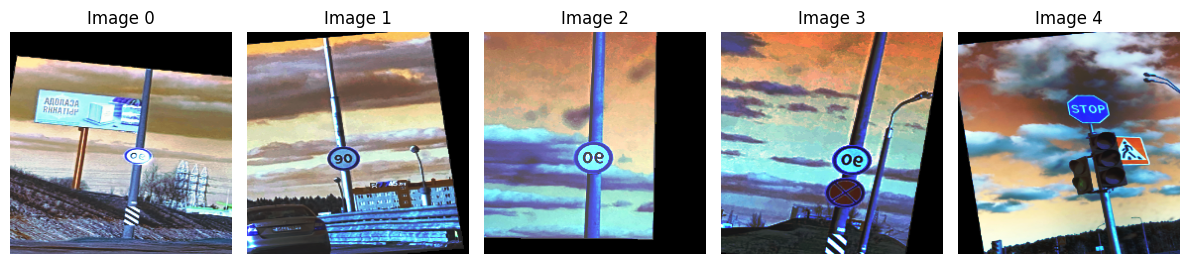

In [23]:
import matplotlib.pyplot as plt
indices_to_display = [0, 1, 2, 3, 4]
fig, axes = plt.subplots(1, 5, figsize=(12, 4))

for i, idx in enumerate(indices_to_display):
    image = features[idx]
    axes[i].imshow(image)
    axes[i].set_title(f'Image {idx}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()

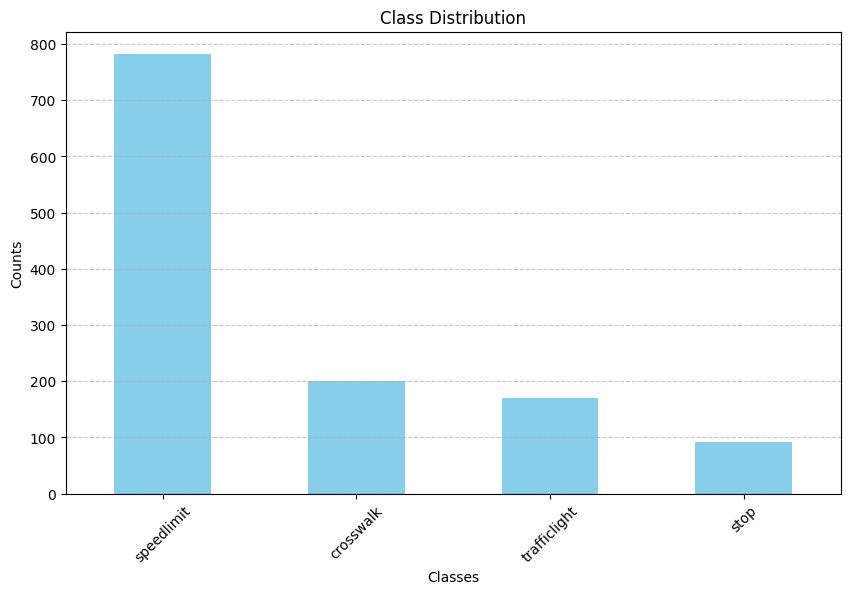

In [ ]:
class_counts = df['class_label'].value_counts()

plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
plt.hist(df['width'], bins=30, color='purple', edgecolor='black')
plt.title('Distribution of Image Width')
plt.xlabel('Width')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

plt.figure(figsize=(8, 6))
plt.hist(df['height'], bins=30, color='red', edgecolor='black')
plt.title('Distribution of Image Height')
plt.xlabel('Height')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()